In [1]:
import torch, platform
print("PyTorch", torch.__version__)

PyTorch 2.9.1+cpu


In [2]:
import torch, platform
print("PyTorch", torch.__version__)
print("Python", platform.python_version())

PyTorch 2.9.1+cpu
Python 3.10.19


In [3]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X, y = load_diabetes(return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)
y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test  = y_test.astype(np.float32).reshape(-1, 1)
print("训练集:", X_train.shape, y_train.shape)

训练集: (353, 10) (353, 1)


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
test_ds  = TabularDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)
print("DataLoader 创建完成 | 训练 batch 数:", len(train_loader))

DataLoader 创建完成 | 训练 batch 数: 12


In [5]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(n_features=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


Epoch   1 | train RMSE 172.1419 | test RMSE 162.5031
Epoch  20 | train RMSE 81.9040 | test RMSE 72.2551
Epoch  40 | train RMSE 61.9173 | test RMSE 59.2043
Epoch  60 | train RMSE 56.8989 | test RMSE 56.7128
Epoch  80 | train RMSE 54.7519 | test RMSE 55.0044
Epoch 100 | train RMSE 53.6570 | test RMSE 54.5470
Epoch 120 | train RMSE 52.7201 | test RMSE 53.4177
Epoch 140 | train RMSE 52.2108 | test RMSE 53.2132


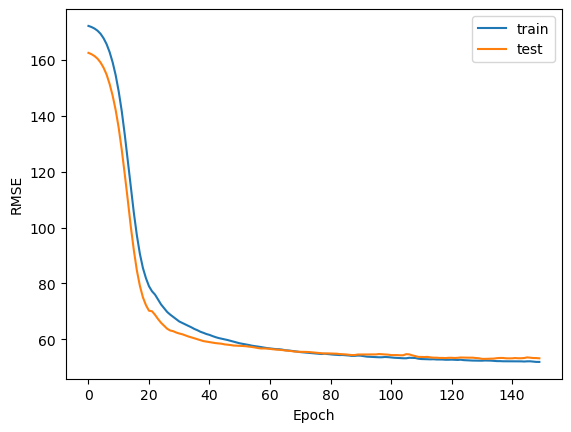

In [7]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 150
train_loss, test_loss = [], []

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss.append(running_loss / len(train_loader.dataset))

    model.eval()
    with torch.no_grad():
        running_loss = 0.
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            running_loss += loss.item() * xb.size(0)
        test_loss.append(running_loss / len(test_loader.dataset))

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | train RMSE {np.sqrt(train_loss[-1]):.4f} | test RMSE {np.sqrt(test_loss[-1]):.4f}")

plt.plot(np.sqrt(train_loss), label='train')
plt.plot(np.sqrt(test_loss), label='test')
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.legend(); plt.show()

In [8]:
torch.save(model.state_dict(), "mlp_diabetes.pt")
print("模型已保存为 mlp_diabetes.pt")

模型已保存为 mlp_diabetes.pt


In [9]:
new_model = MLP(n_features=X_train.shape[1]).to(device)
new_model.load_state_dict(torch.load("mlp_diabetes.pt", map_location=device))
new_model.eval()
with torch.no_grad():
    sample = torch.from_numpy(X_test[:5]).to(device)
    print("预测值:", new_model(sample).cpu().numpy().flatten())
    print("真实值:", y_test[:5].flatten())

预测值: [162.91165  180.73549  143.52109  320.42114  100.260445]
真实值: [219.  70. 202. 230. 111.]
